<a href="https://colab.research.google.com/github/tony-wade/optimizers/blob/main/Demonstration_GuidedSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Conclusion

以下測試為展示 d'Alembert's_formula-inspired sampling method 配合 DE,SA核心概念的 Derivative-Free Optimization (GuidedSA) 之效能。相較於常規DE，其能在**相近計算資源下穩定以4倍速度完成收斂**

Traits

*   Derivative-free optimization with noise robustness, rapid convergence and lightweight implementation  
*   Scalable to high-dimensional complex optimization landscapes

Open Challenges:
  
*   Multi-modal deceptive function optimization in high dimensions (Schwefel)

*   High-dimensional valley-crossing (Rosenbrock-type problems)





### Code for Testing

In [ ]:
!pip install cma
!pip install pymoo

import matplotlib.pyplot as plt
import numpy as np
import time
import cma
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

In [ ]:
# Test functions for optimization

# 深邃多峰/多模態, 可分
def Rastrigin(theta: torch.Tensor) -> torch.Tensor:
    # x: {-5.12, 5.12} for x in theta
    return 10 * theta.numel() + (theta**2 - 10 * torch.cos(2 * math.pi * theta)).sum()

# 平坦的外部+狹窄的全局最優孔
def Ackley(theta: torch.Tensor) -> torch.Tensor:
    # x: [-32.768, 32.768]
    sum_sq = torch.sum(theta**2)
    sum_cos = torch.sum(torch.cos(2 * math.pi * theta))

    term1 = -20 * torch.exp(-0.2 * torch.sqrt(sum_sq / theta.numel()))
    term2 = -torch.exp(sum_cos / theta.numel())

    return term1 + term2 + 20 + math.e

# 緻密多峰, 不可分,
def Griewank(theta: torch.Tensor) -> torch.Tensor:
    # x: [-600, 600]
    d = theta.numel()

    sum_term = torch.sum(theta**2) / 4000

    indices = torch.arange(1, d+1, device=theta.device)
    prod_term = torch.prod(torch.cos(theta / torch.sqrt(indices)))

    return sum_term - prod_term + 1

In [ ]:
def run_experiment_once(seed, target_fn, lower_bound, upper_bound, dim, num_epochs):
    torch.manual_seed(seed)
    np.random.seed(seed)

    x0_np  = np.random.uniform(lower_bound, upper_bound, dim)
    theta0 = torch.from_numpy(x0_np.astype(np.float32)).clone()
    theta0.requires_grad_(True)
    ############################################################
    # GuidedSA
    ############################################################
    params = [theta0]

    def closure():
        return target_fn(theta0)

    sampler = MultiMethodSampler(bounds=(lower_bound, upper_bound), batch_size=20, beta=0.7)
    schedule = SharkTeethAnnealing(initial_temp=100.0, cooling_rate=0.45, annealing_period=1000, frequency_exponent=1.5)

    sa = GuidedSA(
        params,
        sampler=sampler,
        schedule=schedule,
        best_memory_size=10,
        T_greedy=10,
        T_tunnel=60,
        target_loss=1e-4,
        sobol=False      # prevent easy converge
    )

    best_losses = []

    start_sa = time.time()

    for epoch in range(num_epochs):
        sa.step(closure)
        loss = sa.get_loss_value()
        best_loss = sa.get_best_result()
        temperature = sa.get_temperatures()[0]  # 1 group
        best_losses.append(best_loss)

    end_sa = time.time()

    #print(f"[SA] 完成 {num_epochs} epochs，最終 best loss = {best_losses[-1]:.6f}")
    #print(f"總耗時：{end_sa - start_sa:.2f} 秒\n")

    ############################################################
    # CMA-ES
    ############################################################
    sigma0  = 0.5
    popsize = 20
    es = cma.CMAEvolutionStrategy(x0_np, sigma0, {'popsize': popsize, 'verb_disp': 0, 'verb_log': 0, 'verb_plot': 0 })

    cma_best_losses = [None] * num_epochs

    start_cma = time.time()

    for epoch in range(num_epochs):
        solutions = es.ask()
        fitness = []
        solutions_np = np.asarray(solutions, dtype=np.float32)  # shape: (popsize, dim)
        solutions_tensor = torch.from_numpy(solutions_np)

        fitness = [target_fn(solutions_tensor[i]).item() for i in range(solutions_tensor.shape[0])]

        es.tell(solutions, fitness)
        cma_best_losses[epoch] = es.result.fbest

        #if epoch % 500 == 0:
        #    print(f"[CMA] Epoch {epoch:4d} | best_loss = {es.result.fbest:.6f}")

    end_cma = time.time()

    #print(f"[CMA] 完成 {num_epochs} epochs，最終 best loss = {es.result.fbest:.6f}")
    #print(f"總耗時：{end_cma - start_cma:.2f} 秒\n")

    ############################################################
    # DE
    ############################################################
    algorithm = DE(pop_size=20)  # population, equals to batch size in sampler

    # 將 PyTorch 函數整合到 PyMoo Problem 類別中
    class TorchProblem(Problem):
        def __init__(self, target_fn, n_var=100, xl=-5.12, xu=5.12):
            super().__init__(n_var=n_var, xl=xl, xu=xu, n_obj=1)
            self.target_fn = target_fn

        def _evaluate(self, x, out, *args, **kwargs):
            x_tensor = torch.from_numpy(x).float()

            losses = []
            for i in range(x_tensor.shape[0]):
                losses.append(self.target_fn(x_tensor[i, :]))

            # PyMoo need NumPy 陣列傳給 out["F"]
            out["F"] = np.array([loss.item() for loss in losses])


    start_de = time.time()
    res = minimize(
        problem=TorchProblem(target_fn=target_fn, n_var=dim, xl=lower_bound, xu=upper_bound),
        algorithm=algorithm,
        termination=('n_gen', num_epochs),
        verbose=False,
        save_history=True
    )
    end_de = time.time()

    de_best_losses = [gen.opt[0].F[0] for gen in res.history]

    #print(f"[DE] 完成 {num_epochs} epochs，最終 best loss = {res.F[0]:.6f}")
    #print(f"總耗時：{end_de - start_de:.2f} 秒\n")

    return {
        'sa_best_losses': best_losses,
        'cma_best_losses': cma_best_losses,
        'de_best_losses': de_best_losses,

        'sa_time': end_sa - start_sa,
        'cma_time': end_cma - start_cma,
        'de_time': end_de - start_de,
    }


def run_batch_experiments(
    batch_size: int,
    target_fn,
    lower_bound,
    upper_bound,
    dim: int = 100,
    num_epochs: int = 4000,
    base_seed: int = None,
    plot=False,
):
    if base_seed is not None:
        np.random.seed(base_seed)

    seeds = list(np.random.randint(0, 2**31 - 1, size=batch_size))

    all_sa = []
    all_cma = []
    all_de = []
    all_sa_time = []
    all_cma_time = []
    all_de_time = []

    for sd in seeds:
        res = run_experiment_once(sd, target_fn, lower_bound, upper_bound, dim, num_epochs)
        all_sa.append(res['sa_best_losses'])
        all_cma.append(res['cma_best_losses'])
        all_de.append(res['de_best_losses'])

        all_sa_time.append(res['sa_time'])
        all_cma_time.append(res['cma_time'])
        all_de_time.append(res['de_time'])


    final_sa = np.array(all_sa)[:, -1]
    final_cma = np.array(all_cma)[:, -1]
    final_de = np.array(all_de)[:, -1]
    sa_success_rate = np.sum(final_sa  < 1e-4) / batch_size
    cma_success_rate = np.sum(final_cma < 1e-4) / batch_size
    de_success_rate = np.sum(final_de < 1e-4) / batch_size

    avg_sa_time = np.mean(all_sa_time)
    avg_cma_time = np.mean(all_cma_time)
    avg_de_time = np.mean(all_de_time)

    print('Finish','\n')
    print(f"SA success rate: {sa_success_rate * 100}% | Average duraion: {avg_sa_time:.1f}s")
    print(f"CMA-ES success rate: {cma_success_rate  * 100}% | Average duraion: {avg_cma_time:.1f}s")
    print(f"DE success rate: {de_success_rate * 100}% | Average duraion: {avg_de_time:.1f}s")


    if plot is True:
        sa_median = np.median(all_sa, axis=0)
        sa_q1 = np.percentile(all_sa, 25, axis=0)
        sa_q3 = np.percentile(all_sa, 75, axis=0)

        cma_median = np.median(all_cma, axis=0)
        cma_q1 = np.percentile(all_cma, 25, axis=0)
        cma_q3 = np.percentile(all_cma, 75, axis=0)

        de_median = np.median(all_de, axis=0)
        de_q1 = np.percentile(all_de, 25, axis=0)
        de_q3 = np.percentile(all_de, 75, axis=0)

        epochs = np.arange(1, num_epochs + 1)

        plt.figure()
        # SA：median + Q1–Q3
        plt.plot(epochs, sa_median, label='SA median', linewidth=1.2)
        plt.fill_between(
            epochs,
            sa_q1,
            sa_q3,
            alpha=0.3  # transparency
        )

        # CMA-ES：median + Q1–Q3
        plt.plot(epochs, cma_median, label='CMA-ES median', linewidth=1.2)
        plt.fill_between(
            epochs,
            cma_q1,
            cma_q3,
            alpha=0.3
        )

        # DE：median + Q1–Q3
        plt.plot(epochs, de_median, label='DE median', linewidth=1.2)
        plt.fill_between(
            epochs,
            de_q1,
            de_q3,
            alpha=0.3
        )

        plt.xlabel('Iteration (Epoch)')
        plt.ylabel('Best Loss')
        plt.yscale('log')
        plt.ylim(1e-4, 1000)
        plt.title(f"Optimizers on {dim}-D {target_fn.__name__}")
        plt.legend()
        plt.tight_layout()
        plt.show()

### Results

In [ ]:
### Test conditions

dim = 100
target_fn = Rastrigin
lower_bound, upper_bound = -5.12, 5.12
num_epochs = 2000

Group_0 has complete training at 637. 

Group_0 has complete training at 611. 

Group_0 has complete training at 868. 

Group_0 has complete training at 692. 

Group_0 has complete training at 575. 

Group_0 has complete training at 600. 

Group_0 has complete training at 488. 

Group_0 has complete training at 663. 

Group_0 has complete training at 528. 

Group_0 has complete training at 486. 

Finish 

SA success rate: 100.0% | Average duraion: 2.0s
CMA-ES success rate: 0.0% | Average duraion: 24.0s
DE success rate: 0.0% | Average duraion: 19.2s


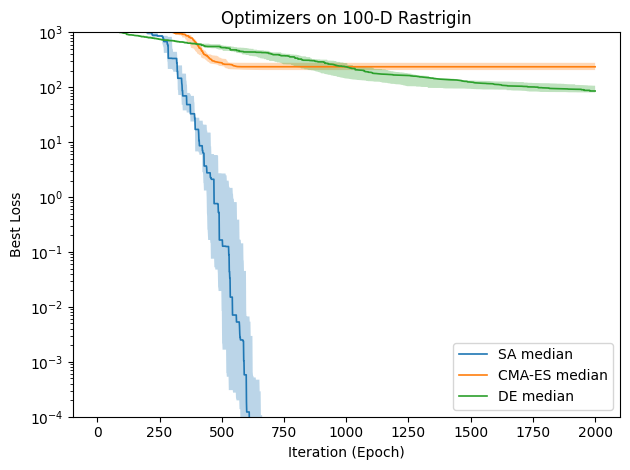

In [ ]:
run_batch_experiments(
    batch_size=10,
    target_fn=target_fn,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    dim=dim,
    num_epochs=num_epochs,
    base_seed=246810,
    plot=True
    )

Group_0 has complete training at 516. 

Group_0 has complete training at 604. 

Group_0 has complete training at 461. 

Group_0 has complete training at 617. 

Group_0 has complete training at 602. 

Group_0 has complete training at 588. 

Group_0 has complete training at 726. 

Group_0 has complete training at 587. 

Group_0 has complete training at 501. 

Group_0 has complete training at 624. 

Finish 

SA success rate: 100.0% | Average duraion: 2.6s
CMA-ES success rate: 100.0% | Average duraion: 26.4s
DE success rate: 0.0% | Average duraion: 22.5s


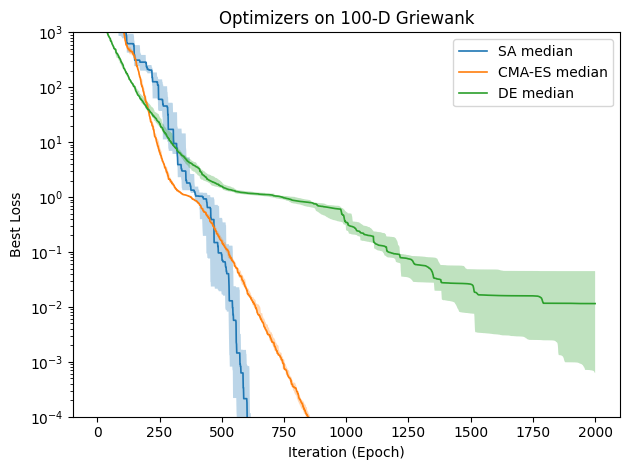

In [ ]:
dim = 100
target_fn = Griewank
lower_bound, upper_bound = -600, 600
num_epochs = 2000


run_batch_experiments(
    batch_size=10,
    target_fn=target_fn,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    dim=dim,
    num_epochs=num_epochs,
    base_seed=1357911,
    plot=True
    )

Group_0 has complete training at 1114. 

Group_0 has complete training at 941. 

Group_0 has complete training at 767. 

Group_0 has complete training at 883. 

Group_0 has complete training at 956. 

Group_0 has complete training at 958. 

Group_0 has complete training at 990. 

Group_0 has complete training at 862. 

Group_0 has complete training at 905. 

Group_0 has complete training at 926. 

Finish 

SA success rate: 100.0% | Average duraion: 4.0s
CMA-ES success rate: 30.0% | Average duraion: 23.9s
DE success rate: 0.0% | Average duraion: 19.0s


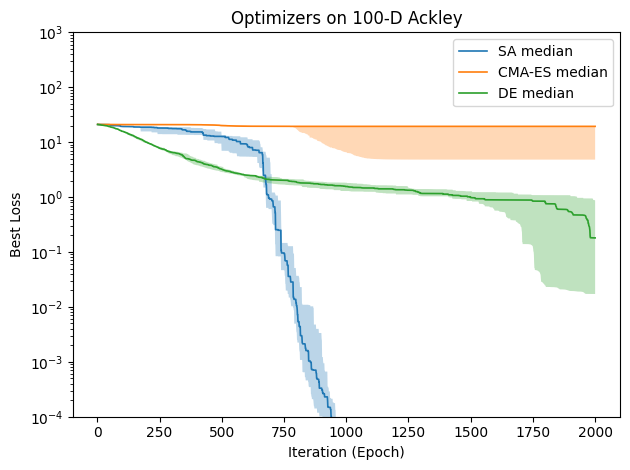

In [ ]:
dim = 100
target_fn = Ackley
lower_bound, upper_bound = -32.768, 32.768
num_epochs = 2000


run_batch_experiments(
    batch_size=10,
    target_fn=target_fn,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    dim=dim,
    num_epochs=num_epochs,
    base_seed=23571113,
    plot=True
    )